In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem Statement

Diberikan data suatu perusahaan asuransi berupa rincian nasabah hasil mengisi form online. Sebagai orang yang bekerja di bidang asuransi anda berkewajiban untuk menilai manakah nasabah yang berhak diberikan pinjaman dan mana yang tidak berdasarkan riwayat dari nasabah-nasabah sebelumnya. Data baru yang terkumpul setiap harinya selalu bertambah pesat, sehingga tidak memungkinkan untuk di lakukan pengecekan secara manual. Anda diminta untuk membuat automasi program yang dapat memprediksi nasabah baru apakah nasabah yang mengajukan pinjaman akan mengalami kesulitan pembayaran atau tidak. Data yang anda miliki adalah sebagai berikut:<br>
Loan_ID : Nomor unik yang diberikan untuk setiap nasabah yang mengajukan pinjaman <br>
Gender : Jenis kelamin nasabah<br>
Married : Status pernikahan nasabah<br>
Dependents : Tanggungan nyawa yang harus ditanggung nasabah<br>
Education : Pendidikan terakhir nasabah<br>
Self_Employed : Status pekerjaan nasabah<br>
ApplicantIncome : Pendapatan nasabah yang mengajukan pinjaman<br>
CoapplicantIncome : Pendapatan pemohon bersama<br>
LoanAmount : Jumlah pinjaman yang diajukan <br>
Loan_Amount_Term : Jangka waktu pinjaman<br>
Credit_History : Riwayat kredit<br>
Property_Area : Kondisi area dari properti yang dimiliki pemohon<br>
Loan_Status : Status pinjaman yang dimiliki, berhutang atau tidak<br>

## 1. Import Libraries and Data

In [ ]:
# Import Package
import os
import pandas as pd
import numpy as np

# Package untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Package untuk cleaning, modelling, dan evaluation model
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# Membuat path untuk mengidentifikasi letak directory
# Catatan : pastikan path yang anda masukkan sesuai dengan directory data anda. Kemungkinan besar path di contoh ini berbeda dengan penyimpanan data anda
path = '/content/drive/My Drive/Kuliah/dataset/'

IMPORT DATA

In [ ]:
# Load data
df = pd.read_csv(os.path.join(path, "loan_prediction.csv"), encoding='utf-8', index_col='Loan_ID')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Dari data diatas maka bisa didapat keterangan bahwa <br>
x = Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area <br>
y = Loan_Status

## 3 Preprocessing

### 3.1. Missing value

In [ ]:
# cek missing value
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Dari hasil cek missing value diketahui bahwa terdapat beberapa data yang menggandung missing value, diantaranya : Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Ammount_Term, Credit_History. Variabel-variabel diatas tidak semua dapat diisi dengan mean, median, atau mode. Tidak juga dihilangkan karena missing value tergolong banyak, dan dapat mereduksi banyak data. Oleh karena itu akan dilakukan analisis mengisi missing value.

In [ ]:
# handdling missing value untuk married
# Membuat kondisi bagi missing value dengan keadaan coapllicant tidak kosong
married_status =((df['Married'].isnull()) & (df['CoapplicantIncome']!=0))

# Jika kondisi benar married dan memiliki coapplicant maka status menikah
df.loc[married_status, "Married"] = "Yes"
# Jika tidak memenuhi kondisi maka belum menikah
df.loc[df['Married'].isnull(),'Married'] = 'No'

In [ ]:
# Handdling missing value untuk gender
married_male = ((df['Gender'].isnull() & (df['Married']=='Yes')) & (df['ApplicantIncome']>df['CoapplicantIncome']))
married_female = ((df['Gender'].isnull() & (df['Married']=='Yes')) & (df['ApplicantIncome']<df['CoapplicantIncome']))
no_married_male = ((df['Gender'].isnull() & (df['Married']=='No')) & (df['ApplicantIncome']<df['CoapplicantIncome']))
no_married_female = ((df['Gender'].isnull() & (df['Married']=='No')) & (df['ApplicantIncome']>df['CoapplicantIncome']))


df.loc[married_male, "Gender"] = "Male"
df.loc[married_female, "Gender"] = "Female"
df.loc[no_married_male, "Gender"] = "Male"
df.loc[no_married_female, "Gender"] = "Female"

In [ ]:
# handdling missing value untuk Deppendent
# Membuat kondisi bagi missing value dengan keadaan tanggungan
dependents_male = (((df['Dependents'].isnull()) & (df['Gender']=="Male")) & (df['Married'] == "Yes"))

# Jika kondisi terpenuhi maka pilih modus
a = df[(df["Gender"] == "Male") & (df["Dependents"] != "0")]
a_1 = a["Dependents"].value_counts().index[0]
df.loc[dependents_male, "Dependents"] = a_1

# Jika tidak memenuhi kondisi maka tidak memiliki tanggungan
df.loc[df['Dependents'].isnull(),'Dependents'] = '0'

In [ ]:
# Selain itu akan diisi dengan modus dan mean untuk beberapa data seperti berikut ini
mmodus = ['Self_Employed','Credit_History']
mmean = ['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term']

for feature in mmean:
        if feature in df.columns.values:
            df[feature] = df[feature].fillna(df[feature].mean())

for feature in mmodus:
        if feature in df.columns.values:
            df[feature] = df[feature].fillna(df[feature].value_counts().index[0])

In [ ]:
# Cek kembali missing value
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

3.2 Label Encoder

In [ ]:
kategori = ['Gender','Married','Education','Self_Employed','Dependents','Credit_History', 'Property_Area','Loan_Status']
df_cat = df[kategori]
df_cat.head()

,Gender,Married,Education,Self_Employed,Dependents,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,
LP001002,Male,No,Graduate,No,0,1.0,Urban,Y
LP001003,Male,Yes,Graduate,No,1,1.0,Rural,N
LP001005,Male,Yes,Graduate,Yes,0,1.0,Urban,Y
LP001006,Male,Yes,Not Graduate,No,0,1.0,Urban,Y
LP001008,Male,No,Graduate,No,0,1.0,Urban,Y


In [ ]:
# Ubah kedalam bentuk numerik
encoded_data = LabelEncoder()

for feature in kategori:
        if feature in df.columns.values:
            df[feature] = encoded_data.fit_transform(df[feature])

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1,2,1
LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1,0,0
LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1,2,1
LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1,2,1
LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1,2,1


### 3.3. Cek Korelasi (Fitur Selection)

In [ ]:
corr_pearson = df.corr()

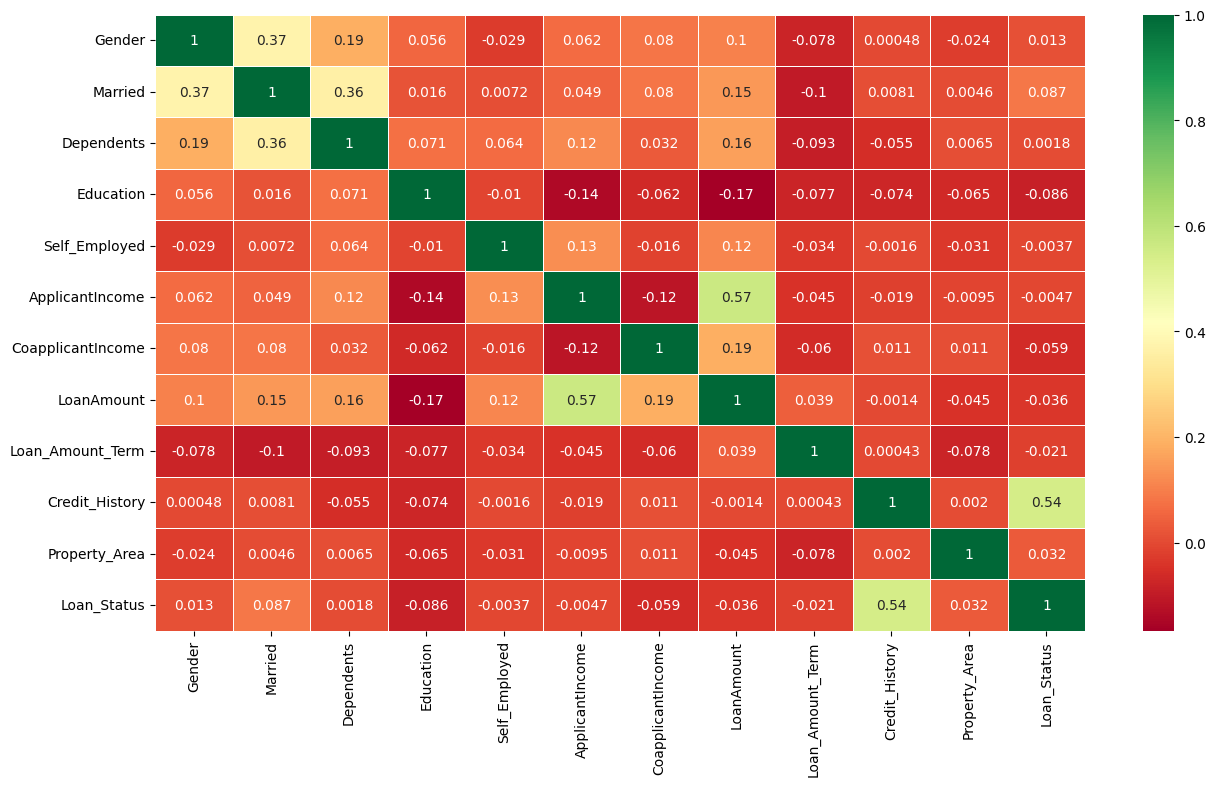

In [ ]:
sns.heatmap(df.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

SCALING
<br>
lakukan Scaling dengan Metode MinMaxScaler
Scaling dibutuhkan karena terdapat perbedaan range nilai yang tinggi diantara beberapa variabel.

In [ ]:
scaler = MinMaxScaler()

scaler.fit(df[['ApplicantIncome']])
df['ApplicantIncome'] = scaler.transform(df[['ApplicantIncome']])

scaler.fit(df[['CoapplicantIncome']])
df['CoapplicantIncome'] = scaler.transform(df[['CoapplicantIncome']])

scaler.fit(df[['LoanAmount']])
df['LoanAmount'] = scaler.transform(df[['LoanAmount']])

scaler.fit(df[['Loan_Amount_Term']])
df['Loan_Amount_Term'] = scaler.transform(df[['Loan_Amount_Term']])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,1,0,0,0,0,0.070489,0.000000,0.198860,0.74359,1,2,1
LP001003,1,1,1,0,0,0.054830,0.036192,0.172214,0.74359,1,0,0
LP001005,1,1,0,0,1,0.035250,0.000000,0.082489,0.74359,1,2,1
LP001006,1,1,0,1,0,0.030093,0.056592,0.160637,0.74359,1,2,1
LP001008,1,0,0,0,0,0.072356,0.000000,0.191027,0.74359,1,2,1


## 5. Membangun Model Klasifikasi

MEMBAGI TRAIN TEST DATA

In [ ]:
#memisahkan antara atribut independen dengan atribut dependen
atr_data = df.drop(columns='Loan_Status')
atr_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001002,1,0,0,0,0,0.070489,0.000000,0.198860,0.74359,1,2
LP001003,1,1,1,0,0,0.054830,0.036192,0.172214,0.74359,1,0
LP001005,1,1,0,0,1,0.035250,0.000000,0.082489,0.74359,1,2
LP001006,1,1,0,1,0,0.030093,0.056592,0.160637,0.74359,1,2
LP001008,1,0,0,0,0,0.072356,0.000000,0.191027,0.74359,1,2


In [ ]:
cls_data = df['Loan_Status']
cls_data.head()

Loan_ID
LP001002    1
LP001003    0
LP001005    1
LP001006    1
LP001008    1
Name: Loan_Status, dtype: int64

In [ ]:
#proses training untuk mendapatkan result (rekomendasi)
#test_size=0.3 -> ukuran split test untuk mendapatkann hasil yang terbaik
X_train, X_test, y_train, y_test = train_test_split(atr_data, cls_data, test_size=0.3, random_state=0)

Model klasifikasi dengan metode **Decision Tree**

In [ ]:
tree_data = DecisionTreeClassifier(random_state=0)
tree_data.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

Hasil PREDIKSI MODEL

In [ ]:
y_predicted = tree_data.predict(X_test)
y_predicted

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
X_test['prediksi'] = y_predicted
X_test['actual'] = y_test
X_test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,prediksi,actual
Loan_ID,,,,,,,,,,,,,
LP002453,1,0,0,0,1,0.085776,0.000000,0.108538,0.74359,1,1,1,1
LP001164,0,0,0,0,0,0.050464,0.000000,0.149059,0.74359,1,1,1,0
LP002734,1,1,0,0,0,0.074001,0.093743,0.455861,0.74359,1,2,0,1
LP002505,1,1,0,0,0,0.051738,0.058824,0.146165,0.74359,1,2,0,0
LP001194,1,1,2,0,0,0.031639,0.028008,0.127352,0.74359,1,1,1,1


In [ ]:
var = ['prediksi', 'actual']
hasil_prediksi = X_test[variabel]
hasil_prediksi

,prediksi,actual
Loan_ID,,
LP002453,1,1
LP001164,1,0
LP002734,0,1
LP002505,0,0
LP001194,1,1
...,...,...
LP001806,1,1
LP002659,0,1
LP002894,1,1


###Lakukan Evaluation Model
Tampikan:
<br>
*   Test accuracy
<br>
*   Test Precision
<br>
*   Test recall
<br>
*   Test f-score



In [49]:
from sklearn import metrics
print("Test Accuracy:", metrics.accuracy_score(y_test, y_predicted))
print("Test Precision:", precision_score(y_test, y_predicted))
print("Test Recall:", recall_score(y_test, y_predicted))
print("Test F-Score:", f1_score(y_test, y_predicted))

Test Accuracy: 0.7135135135135136
Test Precision: 0.7913669064748201
Test Recall: 0.8208955223880597
Test F-Score: 0.8058608058608059
